# Time Series Analysis


Please retrieve daily closing stock price of AT&T using `yahoo finance`. Then, do the following tasks:
    
Question 1. Analyze the descriptive statistics, draw line plot and explain your first impression about the stationarity of the data. 

Question 2. Check the stationarity of the data using acf, pacf, and adf test and interpret if it is stationary.

Question 3. If the series is not stationary, please make it stationary.

Question 4. Model the series using moving average and autoregressive model with an optimum lag.

Questions 5. Visualize the result using train, test data and forecast in a single plot and calculate the predictive performance using RMSE metric.

In [2]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 676 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [13]:
# codes here


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
import datetime
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

In [14]:
stock = 'T'
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2022, 1, 1)
T_close = yf.download(stock, start=start, end=end, interval='1d')['Close']

[*********************100%***********************]  1 of 1 completed


In [15]:
T_close.describe()

count    1008.000000
mean       23.842523
std         2.819279
min        16.744713
25%        21.963745
50%        23.228852
75%        25.519260
max        29.932024
Name: Close, dtype: float64

In [16]:
T_close.head()

Date
2018-01-02    29.108761
2018-01-03    28.436556
2018-01-04    28.700907
2018-01-05    28.806646
2018-01-08    28.889729
Name: Close, dtype: float64

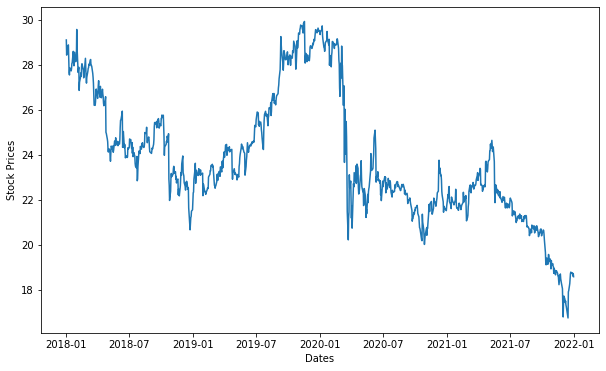

In [17]:
plt.plot(T_close)
plt.xlabel('Dates')
plt.ylabel('Stock Prices')
plt.show()

The stock price decreased from approximately 29 USD to approximately 19 USD between Jan 2018 and Jan 2022, according to the graph.
The stock price also saw various ups and downs during the aforementioned period, reaching a peak of 30 USD in the third quarter of 2019.
It is not stationary as a result. 

##Question 2. Check the stationarity of the data using acf, pacf, and adf test and interpret if it is stationary.(20 pts)

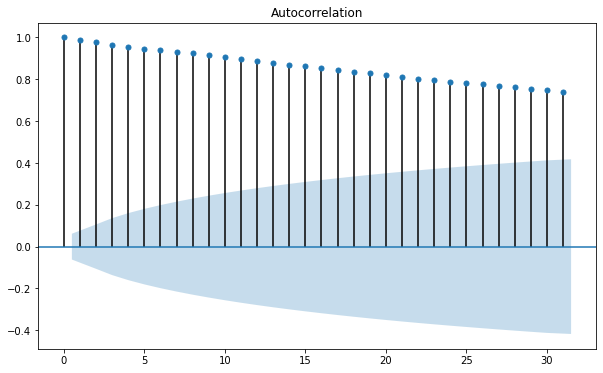

In [18]:
sm.graphics.tsa.plot_acf(T_close);

The ACF graph demonstrates how autocorrelation decays gradually with scale, indicating that the data is not stationary.


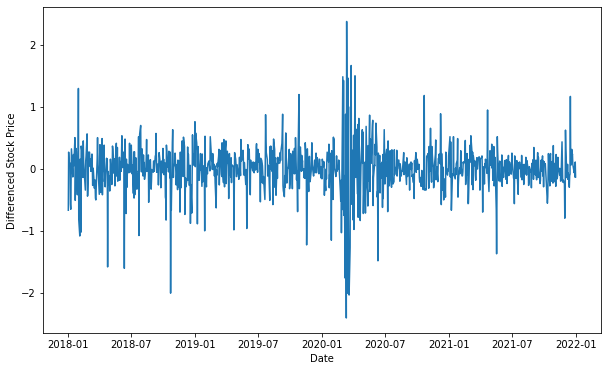

In [19]:
plt.plot(T_close.diff())
plt.xlabel('Date')
plt.ylabel('Differenced Stock Price')
plt.show()

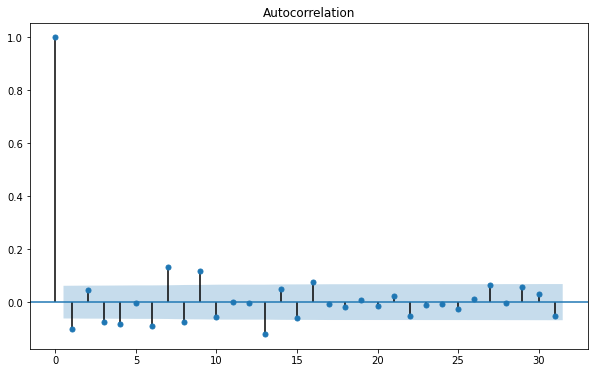

In [21]:
sm.graphics.tsa.plot_acf(T_close.diff().dropna());
#dropping na values

For PACF

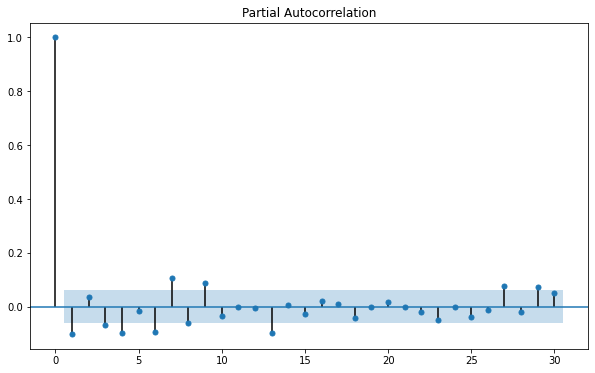

In [22]:
diff_T = T_close.diff().dropna()

sm.graphics.tsa.plot_pacf(diff_T, lags=30)
plt.show()

We can observe by comparing that PACF with the ACF and get the same results and hence we can pick up the 8th lag for our time series analysis.

We are considering 8th lag because for shorter window this is optimal


In [23]:
test_statistics = adfuller(T_close)
print('We have test statistic value is {} and p-value is {}'.format(test_statistics[0],
                                                         test_statistics[1]))

We have test statistic value is -1.4418129395765926 and p-value is 0.5620745579529668


##Question 3. If the series is not stationary, please make it stationary.(20 pts)

We can see that p-value is higher than 0.05, which means that data is not stationary. Now, we can apply differencing as it helps in converting non-stationary data to the stationary one.


In [24]:
test_statistics = adfuller(T_close.diff().dropna())
print('We have test statistic value is {} and p-value is {}'.format(test_statistics[0],
                                                         test_statistics[1]))

We have test statistic value is -9.899017649646874 and p-value is 3.396892365659076e-17


now we can see that the value is much less than 0.05 so now the data is stationary

##Question 4. Model the series using moving average and autoregressive model with an optimum lag.(20 pts)

In [25]:
mvg_avg_blk = diff_T.rolling(window=18).mean()

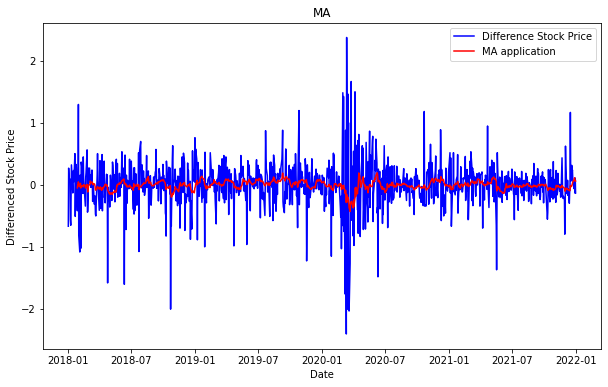

In [30]:
plt.plot(diff_T.loc[start:end].index, diff_T.loc[start:end],
         label='Difference Stock Price', c='b')
plt.plot(mvg_avg_blk.loc[start:end].index, mvg_avg_blk.loc[start:end],
        label='MA application', c='r')
plt.title('MA')
plt.xlabel('Date')
plt.ylabel('Differenced Stock Price')
plt.legend()
plt.show()

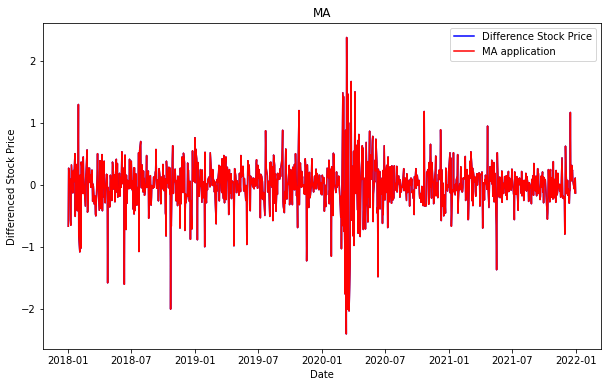

In [38]:
mvg_avg_blk = diff_T.rolling(window=1).mean()
plt.plot(diff_T.loc[start:end].index, diff_T.loc[start:end],
         label='Difference Stock Price', c='b')
plt.plot(mvg_avg_blk.loc[start:end].index, mvg_avg_blk.loc[start:end],
        label='MA application', c='r')
plt.title('MA')
plt.xlabel('Date')
plt.ylabel('Differenced Stock Price')
plt.legend()
plt.show()

It makes alot of difference while we select the small window size

In [39]:
returns = T_close.pct_change()
adfuller(returns.dropna())[1]

6.245032788398068e-18

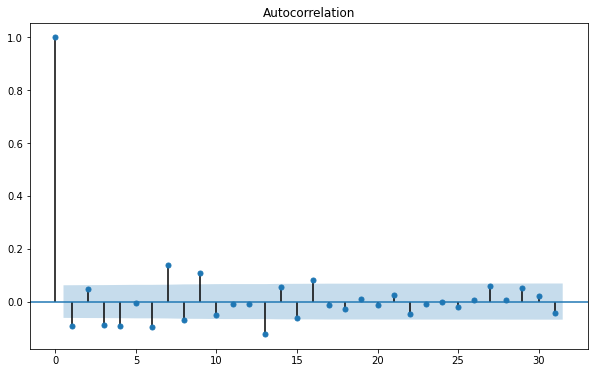

In [40]:
sm.graphics.tsa.plot_acf(returns.dropna());

##Smooting Algorithms

In [49]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
training_len = int(len(T_close) * 0.8)
train = T_close[:training_len]
test = T_close[training_len:]
des_model = Holt(train)
des_result = des_model.fit(smoothing_level=0.3, smoothing_slope=.05)

In [50]:
start_raw = len(train)
end_raw = len(train) + len(test) - 1
des_pred = des_result.predict(start_raw, end_raw)
des_pred.index = test.index

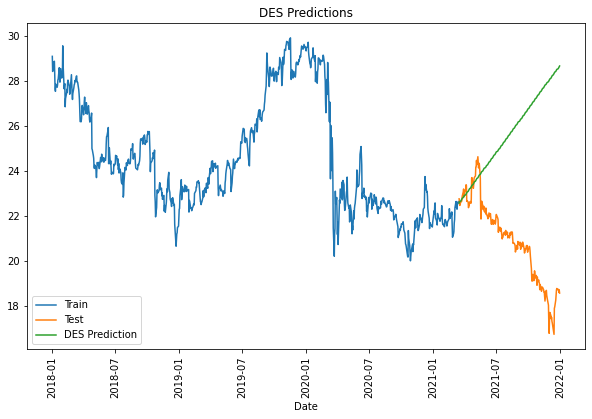

In [51]:
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(des_pred.index, des_pred, label='DES Prediction')
plt.title('DES Predictions')
plt.legend()
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.show()

So from above we can see that slope in test data is downward and hence our predictions did not turn out good. So, predictions and actual data goes inverse of each other

In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mae_des = mean_absolute_error(test, des_pred)
mse_des= mean_squared_error(test, des_pred)
rmse_des = np.sqrt(mean_squared_error(test, des_pred))

In [53]:
des_perf = {'mae_des':mae_des,
'mse_des':mse_des,
'rmse_des':rmse_des}
des_perf = pd.DataFrame([des_perf])
des_perf

,mae_des,mse_des,rmse_des
0,4.808097,34.878236,5.90578


In [56]:
diff_train_len = int(len(diff_T) *0.8)
diff_train = diff_T[:diff_train_len]
diff_test = diff_T[diff_train_len:]
forecast_index = pd.date_range(diff_test.index[-1], periods=10)
des = Holt(T_close).fit()
des_forecast = des.forecast(steps=10)
des_forecast.index = forecast_index

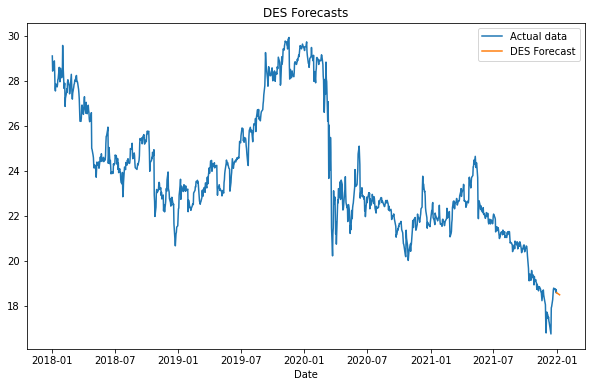

In [58]:
plt.plot(T_close.index, T_close, label='Actual data')
plt.plot(des_forecast.index, des_forecast, label='DES Forecast')
plt.legend()
plt.xlabel('Date')
plt.title('DES Forecasts')
plt.show()

##Questions 5. Visualize the result using train, test data and forecast in a single plot and calculate the predictive performance using RMSE metric.(20 pts)

In [60]:
training_len = int(len(T_close) * 0.8)
train = T_close[:training_len]
test = T_close[training_len:]

In [61]:
prediction = pd.DataFrame()
prediction.index = test.index
prediction['naive_model'] = train[training_len-1]

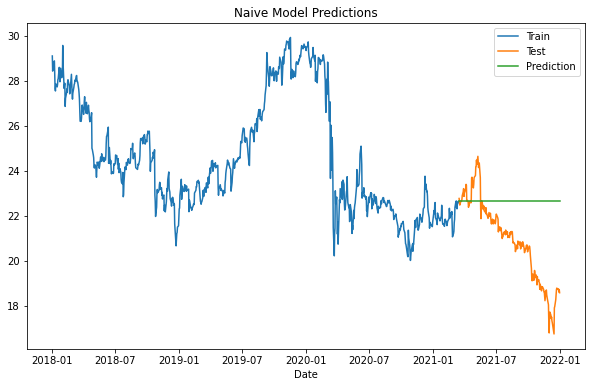

In [62]:
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(prediction['naive_model'], label='Prediction')
plt.title('Naive Model Predictions')
plt.xlabel('Date')
plt.legend()
plt.show()

In [63]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_naive = mean_absolute_error(test, prediction['naive_model'])
mse_naive = mean_squared_error(test, prediction['naive_model'])
rmse_naive = np.sqrt(mean_squared_error(test, prediction['naive_model']))

In [64]:
naive_perf = {'mae_naive': mae_naive,
             'mse_naive':mse_naive,
             'rmse_naive':rmse_naive}
naive_perf = pd.DataFrame([naive_perf])
naive_perf

,mae_naive,mse_naive,rmse_naive
0,2.011717,6.394193,2.528674


In [65]:
import math

MSE = np.square(np.subtract(test, prediction['naive_model'])).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n")
print(RMSE)

Root Mean Square Error:

2.5286742284629202
